
# This notebook/script executes the full workflow to fulfil the study objectives:
# 1) Clean & structure data
# 2) Descriptive statistics & charts
# 3) Hypothesis tests (H1–H3) with econometric models
# 4) Mechanism (price flexibility)
# 5) Robustness (alt outcomes, quantile regression)
# 6) Exports: figures, tables, mini-report skeleton

# ## Step 0 — Setup & Load

In [2]:
import os, json, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# crisp figures (you can change)
plt.rcParams["figure.dpi"] = 140

from pathlib import Path

# ---- paths (edit if needed)
base = Path(".")
data_path = base / "/kaggle/input/dynamic-hotel-pricing/Generated_Dubai_Hotel_Pricing_Data.csv"  # <- update this if your file lives elsewhere
out_dir = base / "/kaggle/working/chapter4_outputs"
fig_dir = out_dir / "/kaggle/working/figures"
tab_dir = out_dir / "/kaggle/working/tables"
out_dir.mkdir(exist_ok=True, parents=True)
fig_dir.mkdir(exist_ok=True, parents=True)
tab_dir.mkdir(exist_ok=True, parents=True)

print("Reading:", data_path.resolve())
df = pd.read_csv(data_path)
print("Loaded shape:", df.shape)
display(df.head(3))

Reading: /kaggle/input/dynamic-hotel-pricing/Generated_Dubai_Hotel_Pricing_Data.csv
Loaded shape: (7000, 19)


,Hotel_ID,Year,Quarter,Hotel_Segment,Star_Rating,Occupancy_Rate,ADR,RevPAR,Price_Change (%),Event_Flag,Performance_Score,Competitor_Price_Avg,Booking_Lead_Time,AI_Pricing_System,Business_Occupancy_Share,Leisure_Occupancy_Share,Booking_Channel_Share,Sustainability_Score,RevPAR_Growth
0,H0103,2024,Q2,Mid-tier,3,59.497655,325.771654,193.826495,-9.738608,0,198.047531,353.140656,16,0,0.387585,0.612415,0.298356,70.071966,2.177739
1,H0309,2023,Q2,Mid-tier,3,55.708153,270.956093,150.944636,0.251698,0,145.553455,259.528490,16,1,0.200000,0.800000,0.742555,83.164451,-3.571628
2,H0682,2023,Q2,Luxury,5,72.489560,441.806644,320.263694,9.763297,0,320.647378,471.546263,29,1,0.635555,0.364445,0.662552,83.324619,0.119803


# ## Step 1 — Data Dictionary & Structure

In [4]:
data_dict = pd.DataFrame({
    "column":[
        "Hotel_ID","Year","Quarter","Hotel_Segment","Star_Rating","Occupancy_Rate",
        "ADR","RevPAR","Price_Change (%)","Event_Flag","Performance_Score",
        "Competitor_Price_Avg","Booking_Lead_Time","AI_Pricing_System",
        "Business_Occupancy_Share","Leisure_Occupancy_Share","Booking_Channel_Share",
        "Sustainability_Score","RevPAR_Growth"
    ],
    "meaning":[
        "Unique hotel identifier",
        "Calendar year (panel time)",
        "Quarter index (seasonality)",
        "Market segment (Luxury/Mid-tier)",
        "Hotel classification (3–5 stars)",
        "Occupancy (%) for the period",
        "Average Daily Rate",
        "Revenue per Available Room",
        "Period-over-period % price change",
        "1=event day / 0=normal day",
        "Composite performance metric",
        "Avg competitor price (market)",
        "Days between booking and stay",
        "1=AI dynamic pricing in use",
        "Share of business travelers",
        "Share of leisure travelers",
        "Booking channel distribution measure",
        "Hotel sustainability score",
        "RevPAR % growth (period over period)"
    ]
})
display(data_dict)


,column,meaning
0,Hotel_ID,Unique hotel identifier
1,Year,Calendar year (panel time)
2,Quarter,Quarter index (seasonality)
3,Hotel_Segment,Market segment (Luxury/Mid-tier)
4,Star_Rating,Hotel classification (3–5 stars)
5,Occupancy_Rate,Occupancy (%) for the period
6,ADR,Average Daily Rate
7,RevPAR,Revenue per Available Room
8,Price_Change (%),Period-over-period % price change
9,Event_Flag,1=event day / 0=normal day


# ## Step 2 — Cleaning & Feature Engineering

In [5]:
# %%
# Cast categories
if "Hotel_Segment" in df.columns:
    df["Hotel_Segment"] = df["Hotel_Segment"].astype("category")
if "Star_Rating" in df.columns:
    df["Star_Rating"] = df["Star_Rating"].astype("category")

# Missing values
na_summary = df.isna().sum().sort_values(ascending=False)
display(na_summary.to_frame("missing_count"))

# Log transforms (safe with +1)
for col in ["RevPAR","ADR","Occupancy_Rate"]:
    if col in df.columns:
        df[f"log_{col}"] = np.log1p(df[col])

# Price volatility proxy (mechanism): |%Δ ADR| within hotel over time
if set(["Hotel_ID","Year","Quarter","ADR"]).issubset(df.columns):
    df = df.sort_values(["Hotel_ID","Year","Quarter"], kind="mergesort")
    df["ADR_pct_change"] = df.groupby("Hotel_ID")["ADR"].pct_change()
    df["Price_Volatility"] = df["ADR_pct_change"].abs()

# Anticipatory pricing (robustness): event flag lagged 1 period
if set(["Hotel_ID","Event_Flag"]).issubset(df.columns):
    df["Event_Flag_Lag1"] = df.groupby("Hotel_ID")["Event_Flag"].shift(1).fillna(0)

# Save cleaned snapshot
clean_path = out_dir / "cleaned_dataset.csv"
df.to_csv(clean_path, index=False)
print("Saved cleaned dataset →", clean_path.resolve())


,missing_count
Hotel_ID,0
Year,0
Quarter,0
Hotel_Segment,0
Star_Rating,0
Occupancy_Rate,0
ADR,0
RevPAR,0
Price_Change (%),0
Event_Flag,0


Saved cleaned dataset → /kaggle/working/chapter4_outputs/cleaned_dataset.csv


# ## Step 3 — Descriptive Statistics (align to objectives)

In [6]:
# %%
overview = {
    "rows": len(df),
    "unique_hotels": df["Hotel_ID"].nunique() if "Hotel_ID" in df.columns else None,
    "years": sorted(df["Year"].unique().tolist()) if "Year" in df.columns else None,
    "segments": sorted(df["Hotel_Segment"].astype(str).unique().tolist()) if "Hotel_Segment" in df.columns else None,
    "star_ratings": sorted(df["Star_Rating"].astype(int).unique().tolist()) if "Star_Rating" in df.columns else None,
}
print(json.dumps(overview, indent=2))

by_year = df.groupby("Year").agg(
    avg_occ=("Occupancy_Rate","mean"),
    avg_ADR=("ADR","mean"),
    avg_RevPAR=("RevPAR","mean"),
    avg_revpar_growth=("RevPAR_Growth","mean")
).round(2).reset_index()
by_year.to_csv(tab_dir/"by_year.csv", index=False)
display(by_year)

ai_comp = df.groupby("AI_Pricing_System").agg(
    count=("Hotel_ID","count"),
    avg_occ=("Occupancy_Rate","mean"),
    avg_ADR=("ADR","mean"),
    avg_RevPAR=("RevPAR","mean"),
    avg_revpar_growth=("RevPAR_Growth","mean")
).round(2).reset_index().rename(columns={"AI_Pricing_System":"AI_Enabled"})
ai_comp.to_csv(tab_dir/"ai_vs_nonai.csv", index=False)
display(ai_comp)

event_comp = df.groupby("Event_Flag").agg(
    count=("Hotel_ID","count"),
    avg_occ=("Occupancy_Rate","mean"),
    avg_ADR=("ADR","mean"),
    avg_RevPAR=("RevPAR","mean")
).round(2).reset_index().rename(columns={"Event_Flag":"Event_Day"})
event_comp.to_csv(tab_dir/"event_vs_nonevent.csv", index=False)
display(event_comp)

stars = df.groupby("Star_Rating").agg(
    count=("Hotel_ID","count"),
    avg_occ=("Occupancy_Rate","mean"),
    avg_ADR=("ADR","mean"),
    avg_RevPAR=("RevPAR","mean")
).round(2).reset_index()
stars.to_csv(tab_dir/"by_star_rating.csv", index=False)
display(stars)

{
  "rows": 7000,
  "unique_hotels": 999,
  "years": [
    2022,
    2023,
    2024
  ],
  "segments": [
    "Luxury",
    "Mid-tier"
  ],
  "star_ratings": [
    3,
    4,
    5
  ]
}


,Year,avg_occ,avg_ADR,avg_RevPAR,avg_revpar_growth
0,2022,69.93,373.72,265.88,0.95
1,2023,69.68,374.06,264.44,1.98
2,2024,70.01,375.43,266.56,2.04


,AI_Enabled,count,avg_occ,avg_ADR,avg_RevPAR,avg_revpar_growth
0,0,1768,65.01,300.51,195.43,1.57
1,1,5232,71.52,399.37,289.35,1.68


,Event_Day,count,avg_occ,avg_ADR,avg_RevPAR
0,0,5843,69.91,374.76,266.10
1,1,1157,69.68,372.56,263.25


/tmp/ipykernel_36/3530646716.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stars = df.groupby("Star_Rating").agg(


,Star_Rating,count,avg_occ,avg_ADR,avg_RevPAR
0,3,1790,64.56,299.91,193.69
1,4,1735,64.79,300.39,194.69
2,5,3475,75.15,449.72,338.10


# ## Step 4 — Visualizations (matplotlib only; each chart in its own cell)

/tmp/ipykernel_36/147333330.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_year_seg = df.groupby(["Year","Hotel_Segment"])["ADR"].mean().reset_index()


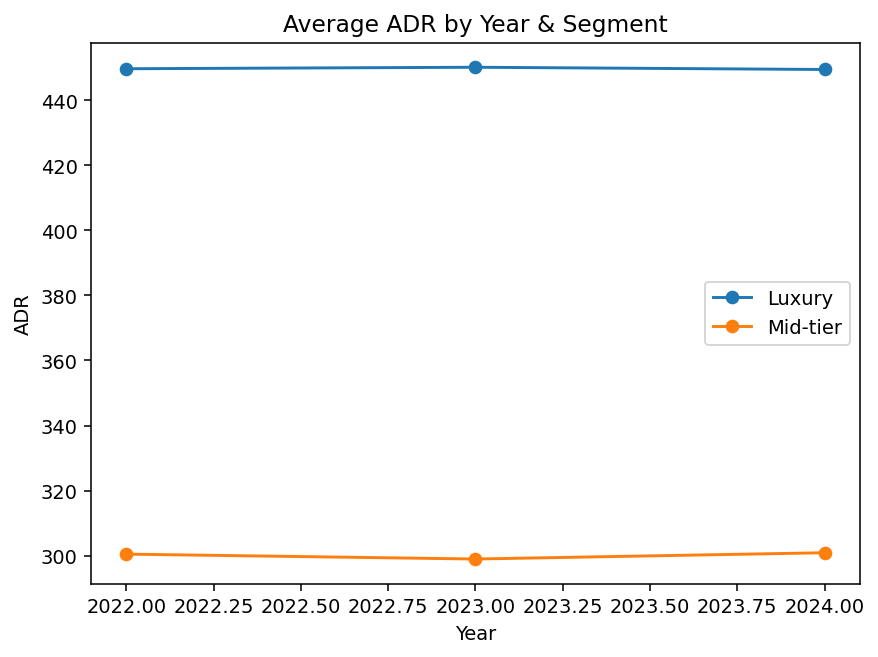

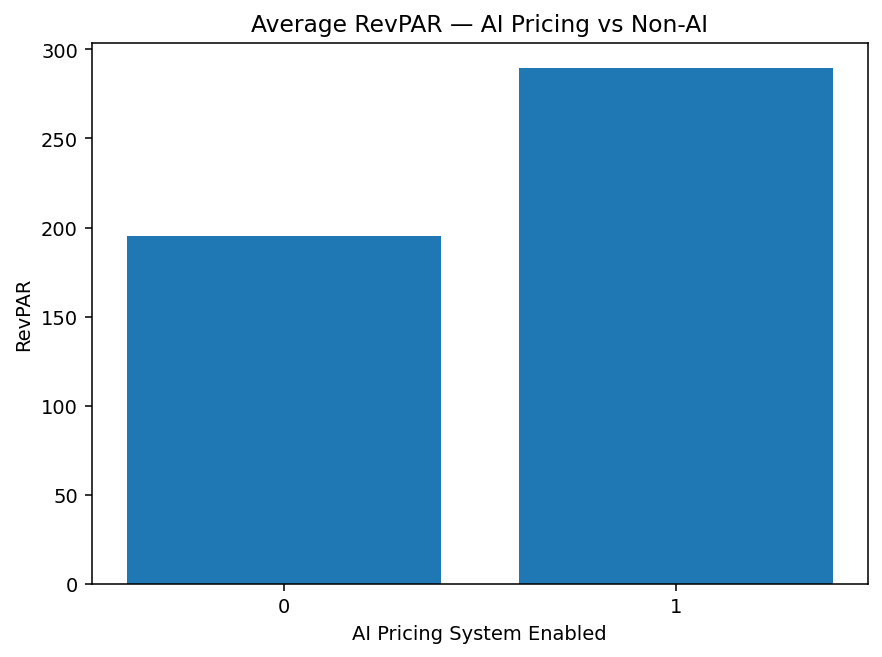

<Figure size 896x672 with 0 Axes>

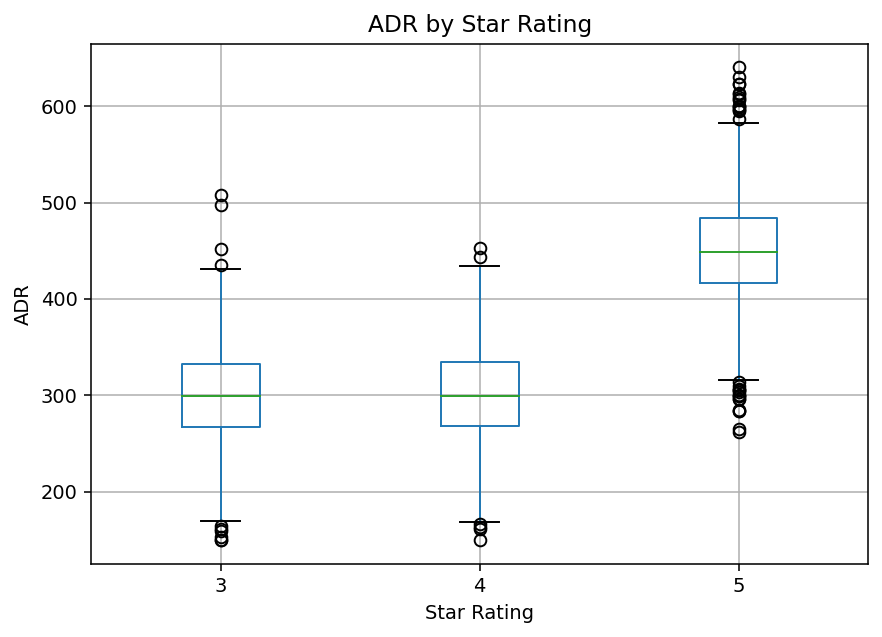

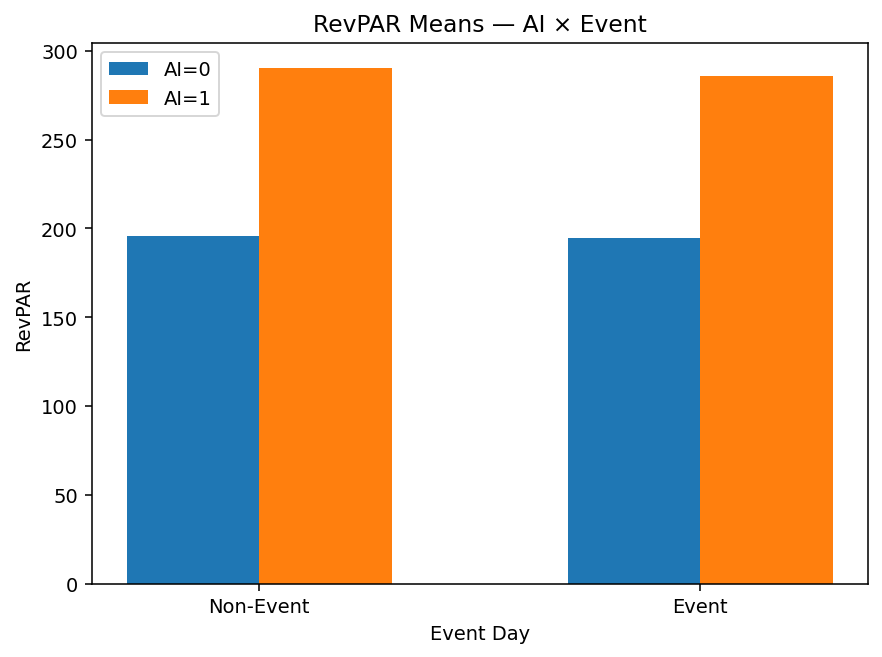

In [7]:
# %%
# 4.1 ADR by Year & Segment (line)
if set(["Year","Hotel_Segment","ADR"]).issubset(df.columns):
    by_year_seg = df.groupby(["Year","Hotel_Segment"])["ADR"].mean().reset_index()
    plt.figure()
    for seg in by_year_seg["Hotel_Segment"].astype(str).unique():
        sub = by_year_seg[by_year_seg["Hotel_Segment"].astype(str)==seg]
        plt.plot(sub["Year"], sub["ADR"], marker="o", label=str(seg))
    plt.title("Average ADR by Year & Segment")
    plt.xlabel("Year"); plt.ylabel("ADR"); plt.legend(); plt.tight_layout()
    plt.savefig(fig_dir/"adr_by_year_segment.png")
    plt.show()

# %%
# 4.2 RevPAR: AI vs Non-AI (bar)
if set(["AI_Pricing_System","RevPAR"]).issubset(df.columns):
    ai_bar = df.groupby("AI_Pricing_System")["RevPAR"].mean().reset_index()
    plt.figure()
    plt.bar(ai_bar["AI_Pricing_System"].astype(str), ai_bar["RevPAR"])
    plt.title("Average RevPAR — AI Pricing vs Non-AI")
    plt.xlabel("AI Pricing System Enabled"); plt.ylabel("RevPAR"); plt.tight_layout()
    plt.savefig(fig_dir/"revpar_ai_vs_nonai.png")
    plt.show()

# %%
# 4.3 ADR by Star Rating (boxplot)
if set(["Star_Rating","ADR"]).issubset(df.columns):
    plt.figure()
    df.boxplot(column="ADR", by="Star_Rating")
    plt.title("ADR by Star Rating")
    plt.suptitle("")
    plt.xlabel("Star Rating"); plt.ylabel("ADR"); plt.tight_layout()
    plt.savefig(fig_dir/"adr_by_star_box.png")
    plt.show()

# %%
# 4.4 Interaction Means: AI × Event on RevPAR (grouped bars)
import numpy as np
if set(["AI_Pricing_System","Event_Flag","RevPAR"]).issubset(df.columns):
    cell_means = df.groupby(["AI_Pricing_System","Event_Flag"])["RevPAR"].mean().reset_index()
    labels = ["Non-Event","Event"]
    plt.figure()
    for ai_status in sorted(df["AI_Pricing_System"].unique()):
        subset = cell_means[cell_means["AI_Pricing_System"]==ai_status].sort_values("Event_Flag")
        x = np.arange(len(labels)) + (0.15 if ai_status==1 else -0.15)
        plt.bar(x, subset["RevPAR"].values, width=0.3, label=f"AI={ai_status}")
    plt.xticks(np.arange(len(labels)), labels)
    plt.title("RevPAR Means — AI × Event")
    plt.xlabel("Event Day"); plt.ylabel("RevPAR"); plt.legend(); plt.tight_layout()
    plt.savefig(fig_dir/"revpar_ai_by_event.png")
    plt.show()


# ## Step 5 — Hypothesis Tests (H1–H3): T-tests


In [8]:
# %%
from scipy.stats import ttest_ind

def ttest_print(col):
    a = df[df["AI_Pricing_System"]==1][col].dropna()
    b = df[df["AI_Pricing_System"]==0][col].dropna()
    t, p = ttest_ind(a, b, equal_var=False)
    print(f"T-test {col} (AI=1 vs 0): t={t:.3f}, p={p:.6f}, mean_AI={a.mean():.2f}, mean_nonAI={b.mean():.2f}")

for metric in ["RevPAR","ADR","Occupancy_Rate"]:
    if metric in df.columns:
        ttest_print(metric)

T-test RevPAR (AI=1 vs 0): t=58.224, p=0.000000, mean_AI=289.35, mean_nonAI=195.43
T-test ADR (AI=1 vs 0): t=59.165, p=0.000000, mean_AI=399.37, mean_nonAI=300.51
T-test Occupancy_Rate (AI=1 vs 0): t=22.883, p=0.000000, mean_AI=71.52, mean_nonAI=65.01


# ## Step 6 — Econometric Models (OLS with Clustered SEs)  
# H1: AI improves revenue (RevPAR).  
# H2: AI effect is stronger on event days (AI × Event).  
# H3: Segment moderates AI effect (AI × Segment).

In [9]:
# %%
import statsmodels.api as sm
import statsmodels.formula.api as smf

base_cols = ["RevPAR","AI_Pricing_System","Event_Flag","Star_Rating","Hotel_Segment","Year","Hotel_ID"]
work = df.dropna(subset=[c for c in base_cols if c in df.columns]).copy()

# Model 1 — H1
m1 = smf.ols("RevPAR ~ AI_Pricing_System + C(Star_Rating) + C(Hotel_Segment) + C(Year)", data=work)\
       .fit(cov_type="cluster", cov_kwds={"groups": work["Hotel_ID"]})
print("\n[Model 1] RevPAR ~ AI + controls"); display(m1.summary())

# Model 2 — H2 (AI × Event)
m2 = smf.ols("RevPAR ~ AI_Pricing_System*Event_Flag + C(Star_Rating) + C(Hotel_Segment) + C(Year)", data=work)\
       .fit(cov_type="cluster", cov_kwds={"groups": work["Hotel_ID"]})
print("\n[Model 2] RevPAR ~ AI * Event + controls"); display(m2.summary())

# Model 3 — H3 (AI × Segment)
m3 = smf.ols("RevPAR ~ AI_Pricing_System*C(Hotel_Segment) + C(Star_Rating) + C(Year)", data=work)\
       .fit(cov_type="cluster", cov_kwds={"groups": work["Hotel_ID"]})
print("\n[Model 3] RevPAR ~ AI * Segment + controls"); display(m3.summary())

# Save compact coefficient tables
def save_coef_table(model, name):
    ct = model.params.to_frame("coef")
    ct["std_err"] = model.bse
    ct["t"] = model.tvalues
    ct["p"] = model.pvalues
    path = tab_dir / f"coef_{name}.csv"
    ct.to_csv(path)
    print("Saved:", path.resolve())

save_coef_table(m1, "m1_ai_base")
save_coef_table(m2, "m2_ai_event")
save_coef_table(m3, "m3_ai_segment")


[Model 1] RevPAR ~ AI + controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RevPAR   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                 3.041e+04
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:03:33   Log-Likelihood:                -37639.
No. Observations:                7000   AIC:                         7.529e+04
Df Residuals:                    6994   BIC:                         7.533e+04
Df Model:                           5                                         
Covariance Type:              cluster                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      179.1872      1.071    167.247      0.000     177.087     181.287
C(Star_Rating)[T.4]              0.9729      1.452      0.670      0.503      -1.874       3.819
C(Star_Rating)[T.5]            162.4143      1.114    145.781      0.000     160.231     164.598
C(Hotel_Segment)[T.Mid-tier]    16.7729      0.809     20.737      0.000      15.188      18.358
C(Year)[T.2023]                 -2.2412      1.527     -1.468      0.142      -5.234       0.752
C(Year)[T.2024]                 -0.8706      1.527     -0.570      0.569      -3.864       2.123
AI_Pricing_System               -2.4673      1.498     -1.648      0.099      -5.402       0.468
==============================================================================
Omnibus:                      107.363   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.313
Skew:                           0.270   Prob(JB):                     2.04e-26
Kurtosis:                       3.338   Cond. No.                     3.86e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.13e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


[Model 2] RevPAR ~ AI * Event + controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RevPAR   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                 2.291e+04
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:03:33   Log-Likelihood:                -37638.
No. Observations:                7000   AIC:                         7.529e+04
Df Residuals:                    6992   BIC:                         7.535e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      179.0587      1.122    159.520      0.000     176.859     181.259
C(Star_Rating)[T.4]              0.9802      1.453      0.675      0.500      -1.867       3.827
C(Star_Rating)[T.5]            162.3457      1.130    143.731      0.000     160.132     164.559
C(Hotel_Segment)[T.Mid-tier]    16.7130      0.821     20.345      0.000      15.103      18.323
C(Year)[T.2023]                 -1.8174      1.591     -1.142      0.253      -4.936       1.302
C(Year)[T.2024]                 -0.4304      1.581     -0.272      0.785      -3.529       2.668
AI_Pricing_System               -2.2085      1.636     -1.350      0.177      -5.415       0.998
Event_Flag                      -0.5861      2.946     -0.199      0.842      -6.359       5.187
AI_Pricing_System:Event_Flag    -1.5425      3.537     -0.436      0.663      -8.475       5.390
==============================================================================
Omnibus:                      107.096   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.962
Skew:                           0.270   Prob(JB):                     2.43e-26
Kurtosis:                       3.337   Cond. No.                     2.74e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 2.28e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


[Model 3] RevPAR ~ AI * Segment + controls


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RevPAR   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                 3.041e+04
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:03:33   Log-Likelihood:                -37639.
No. Observations:                7000   AIC:                         7.529e+04
Df Residuals:                    6994   BIC:                         7.533e+04
Df Model:                           5                                         
Covariance Type:              cluster                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                        158.5770      0.860    184.380      0.000     156.891     160.263
C(Hotel_Segment)[T.Mid-tier]                      37.3831      0.806     46.377      0.000      35.803      38.963
C(Star_Rating)[T.4]                                0.9729      1.452      0.670      0.503      -1.874       3.820
C(Star_Rating)[T.5]                              121.1939      0.645    188.013      0.000     119.931     122.457
C(Year)[T.2023]                                   -2.2412      1.527     -1.467      0.142      -5.235       0.752
C(Year)[T.2024]                                   -0.8706      1.527     -0.570      0.569      -3.864       2.123
AI_Pricing_System                                 59.3633      0.723     82.161      0.000      57.947      60.779
AI_Pricing_System:C(Hotel_Segment)[T.Mid-tier]   -61.8306      0.898    -68.820      0.000     -63.592     -60.070
==============================================================================
Omnibus:                      107.363   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.313
Skew:                           0.270   Prob(JB):                     2.04e-26
Kurtosis:                       3.338   Cond. No.                     4.15e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.01e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Saved: /kaggle/working/tables/coef_m1_ai_base.csv
Saved: /kaggle/working/tables/coef_m2_ai_event.csv
Saved: /kaggle/working/tables/coef_m3_ai_segment.csv


# ### Step 6b — Hotel Fixed Effects (optional; can be heavy)
# Toggle `run_hotel_fe=True` to run; includes C(Hotel_ID) dummies.


In [10]:
# %%
run_hotel_fe = False  # set True to execute (can be slow)

if run_hotel_fe:
    m_fe = smf.ols("RevPAR ~ AI_Pricing_System + Event_Flag + C(Star_Rating) + C(Year) + C(Hotel_Segment) + C(Hotel_ID)",
                   data=work).fit(cov_type="cluster", cov_kwds={"groups": work["Hotel_ID"]})
    display(m_fe.summary())
    save_coef_table(m_fe, "m_fe_hotel")
    with open(tab_dir/"model_fe_revpar_summary.txt","w") as f:
        f.write(m_fe.summary().as_text())
else:
    print("Hotel FE skipped (set run_hotel_fe=True to run).")


Hotel FE skipped (set run_hotel_fe=True to run).


# ## Step 7 — Mechanism: Price Flexibility via Price Volatility


In [13]:
if "Price_Volatility" in work.columns:
    mech_df = work.dropna(subset=["Price_Volatility"]).copy()  # drop NAs
    mm = smf.ols(
        "Price_Volatility ~ AI_Pricing_System + Event_Flag + C(Star_Rating) + C(Hotel_Segment) + C(Year)",
        data=mech_df
    ).fit(cov_type="cluster", cov_kwds={"groups": mech_df["Hotel_ID"]})
    
    display(mm.summary())
    
    # Save coefficients
    coef = mm.params.to_frame("coef")
    coef["std_err"] = mm.bse
    coef["t"] = mm.tvalues
    coef["p"] = mm.pvalues
    coef.to_csv(tab_dir/"coef_mechanism_price_volatility.csv")
    
    with open(tab_dir/"mechanism_price_volatility_summary.txt","w") as f:
        f.write(mm.summary().as_text())
    
    print("Mechanism model executed & saved → tables/")
else:
    print("Price_Volatility column missing; skipped mechanism test.")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Price_Volatility   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1282.
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:05:19   Log-Likelihood:                -133.11
No. Observations:                6001   AIC:                             280.2
Df Residuals:                    5994   BIC:                             327.1
Df Model:                           6                                         
Covariance Type:              cluster                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.1971      0.005     36.432      0.000       0.187       0.208
C(Star_Rating)[T.4]             -0.0108      0.006     -1.920      0.055      -0.022       0.000
C(Star_Rating)[T.5]              0.1382      0.005     26.205      0.000       0.128       0.149
C(Hotel_Segment)[T.Mid-tier]     0.0589      0.004     15.536      0.000       0.051       0.066
C(Year)[T.2023]                  0.0132      0.009      1.508      0.132      -0.004       0.030
C(Year)[T.2024]                  0.0120      0.009      1.356      0.175      -0.005       0.029
AI_Pricing_System               -0.0030      0.006     -0.533      0.594      -0.014       0.008
Event_Flag                      -0.0045      0.008     -0.534      0.593      -0.021       0.012
==============================================================================
Omnibus:                     1593.672   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4556.853
Skew:                           1.389   Prob(JB):                         0.00
Kurtosis:                       6.241   Cond. No.                     3.96e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 9.59e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Mechanism model executed & saved → tables/


# ## Step 8 — Robustness Checks
# 1) Alternative outcomes (ADR, Occupancy)  
# 2) Quantile regression for RevPAR (25/50/75th percentiles)

In [14]:
# %%
# Alt outcomes: ADR, Occupancy
if "ADR" in work.columns:
    rb1 = smf.ols("ADR ~ AI_Pricing_System*Event_Flag + C(Star_Rating) + C(Hotel_Segment) + C(Year)",
                  data=work).fit(cov_type="cluster", cov_kwds={"groups": work["Hotel_ID"]})
    display(rb1.summary())
    save_coef_table(rb1, "robust_adr")

if "Occupancy_Rate" in work.columns:
    rb2 = smf.ols("Occupancy_Rate ~ AI_Pricing_System*Event_Flag + C(Star_Rating) + C(Hotel_Segment) + C(Year)",
                  data=work).fit(cov_type="cluster", cov_kwds={"groups": work["Hotel_ID"]})
    display(rb2.summary())
    save_coef_table(rb2, "robust_occupancy_rate")

# Quantile regression
try:
    from statsmodels.regression.quantile_regression import QuantReg
    X = pd.get_dummies(work[["AI_Pricing_System","Event_Flag","Star_Rating","Hotel_Segment","Year"]], drop_first=True)
    X = sm.add_constant(X)
    qr = QuantReg(work["RevPAR"], X)
    for q in [0.25, 0.50, 0.75]:
        res = qr.fit(q=q)
        with open(tab_dir/f"quantreg_revpar_q{int(q*100)}.txt","w") as f:
            f.write(res.summary().as_text())
    print("Quantile regression summaries saved in:", tab_dir.resolve())
except Exception as e:
    print("Quantile regression skipped due to:", e)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ADR   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                 5.409e+04
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:05:39   Log-Likelihood:                -37260.
No. Observations:                7000   AIC:                         7.454e+04
Df Residuals:                    6992   BIC:                         7.459e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      250.2155      1.106    226.268      0.000     248.048     252.383
C(Star_Rating)[T.4]              0.4698      1.591      0.295      0.768      -2.649       3.588
C(Star_Rating)[T.5]            200.1854      1.125    177.997      0.000     197.981     202.390
C(Hotel_Segment)[T.Mid-tier]    50.0301      0.860     58.190      0.000      48.345      51.715
C(Year)[T.2023]                 -0.1287      1.493     -0.086      0.931      -3.054       2.797
C(Year)[T.2024]                  0.5001      1.505      0.332      0.740      -2.450       3.451
AI_Pricing_System               -0.4831      1.723     -0.280      0.779      -3.861       2.895
Event_Flag                      -0.5428      3.104     -0.175      0.861      -6.627       5.542
AI_Pricing_System:Event_Flag    -1.4091      3.568     -0.395      0.693      -8.402       5.584
==============================================================================
Omnibus:                        2.855   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                2.898
Skew:                           0.025   Prob(JB):                        0.235
Kurtosis:                       3.087   Cond. No.                     2.74e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 2.28e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Saved: /kaggle/working/tables/coef_robust_adr.csv


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Occupancy_Rate   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                 4.410e+04
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:05:39   Log-Likelihood:                -26018.
No. Observations:                7000   AIC:                         5.205e+04
Df Residuals:                    6992   BIC:                         5.211e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       46.9803      0.236    199.273      0.000      46.518      47.442
C(Star_Rating)[T.4]              0.2178      0.330      0.660      0.509      -0.429       0.865
C(Star_Rating)[T.5]             28.9523      0.223    129.839      0.000      28.515      29.389
C(Hotel_Segment)[T.Mid-tier]    18.0280      0.181     99.763      0.000      17.674      18.382
C(Year)[T.2023]                 -0.2692      0.301     -0.894      0.371      -0.859       0.321
C(Year)[T.2024]                 -0.0028      0.298     -0.010      0.992      -0.586       0.580
AI_Pricing_System               -0.6667      0.368     -1.810      0.070      -1.389       0.055
Event_Flag                      -0.1113      0.652     -0.171      0.864      -1.388       1.166
AI_Pricing_System:Event_Flag    -0.0192      0.766     -0.025      0.980      -1.521       1.482
==============================================================================
Omnibus:                        3.493   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                3.336
Skew:                          -0.021   Prob(JB):                        0.189
Kurtosis:                       2.902   Cond. No.                     2.74e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 2.28e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Saved: /kaggle/working/tables/coef_robust_occupancy_rate.csv
Quantile regression skipped due to: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).


# ## Step 9 — Mini Report Skeleton & Output Index

In [15]:
# %%
report_md = out_dir/"Chapter4_Practical_Report.md"
content = f'''
# Chapter 4 — Practical Results (AI Dynamic Pricing, Dubai Hotels)

## Data & Preparation
- Source: {data_path.name}
- Cleaned snapshot: cleaned_dataset.csv

## Descriptive Statistics
- Tables: by_year.csv, ai_vs_nonai.csv, event_vs_nonevent.csv, by_star_rating.csv
- Figures: adr_by_year_segment.png, revpar_ai_vs_nonai.png, adr_by_star_box.png, revpar_ai_by_event.png

## Hypotheses & Models
- H1 (AI improves RevPAR): coef_m1_ai_base.csv
- H2 (AI × Event): coef_m2_ai_event.csv
- H3 (AI × Segment): coef_m3_ai_segment.csv
- Optional FE model: coef_m_fe_hotel.csv (if executed)

## Mechanism
- Price_Volatility model: coef_mechanism_price_volatility.csv

## Robustness
- ADR/Occupancy: coef_robust_adr.csv, coef_robust_occupancy_rate.csv
- Quantile regression: quantreg_revpar_q25/50/75.txt

(Cluster-robust SEs are used with Hotel_ID as the cluster.)
'''
report_md.write_text(content)
print("Report skeleton saved →", report_md.resolve())
print("All outputs saved under →", out_dir.resolve())

Report skeleton saved → /kaggle/working/chapter4_outputs/Chapter4_Practical_Report.md
All outputs saved under → /kaggle/working/chapter4_outputs


# Step 10 — Diagnostics & Validation

Variance Inflation Factors (VIF):


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,0.000000
1,AI_Pricing_System,1.499699
2,Event_Flag,1.085647
3,Year,1.085740
4,Star_Rating_4,1.481239
5,Star_Rating_5,inf
6,Hotel_Segment_Mid-tier,inf


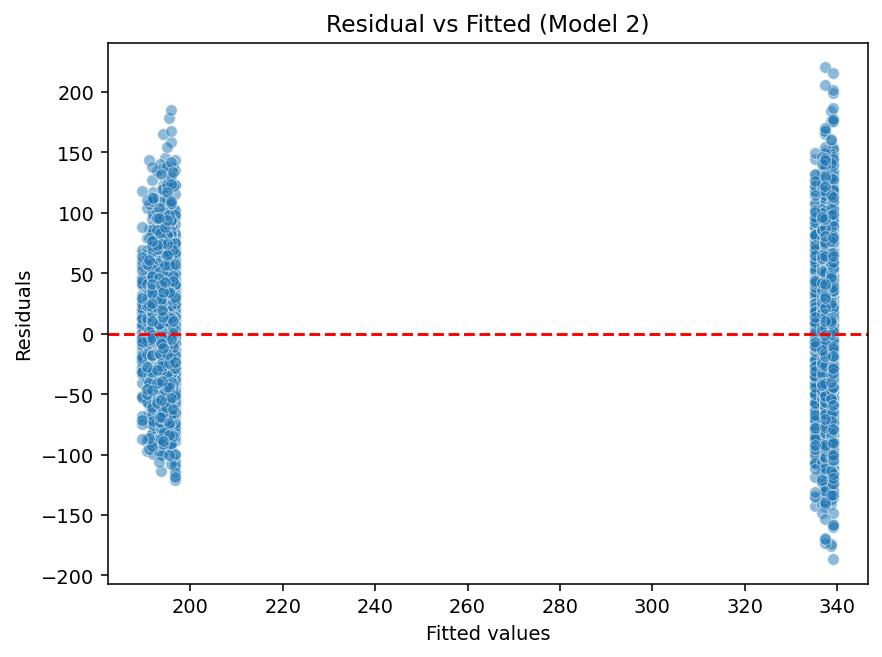

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


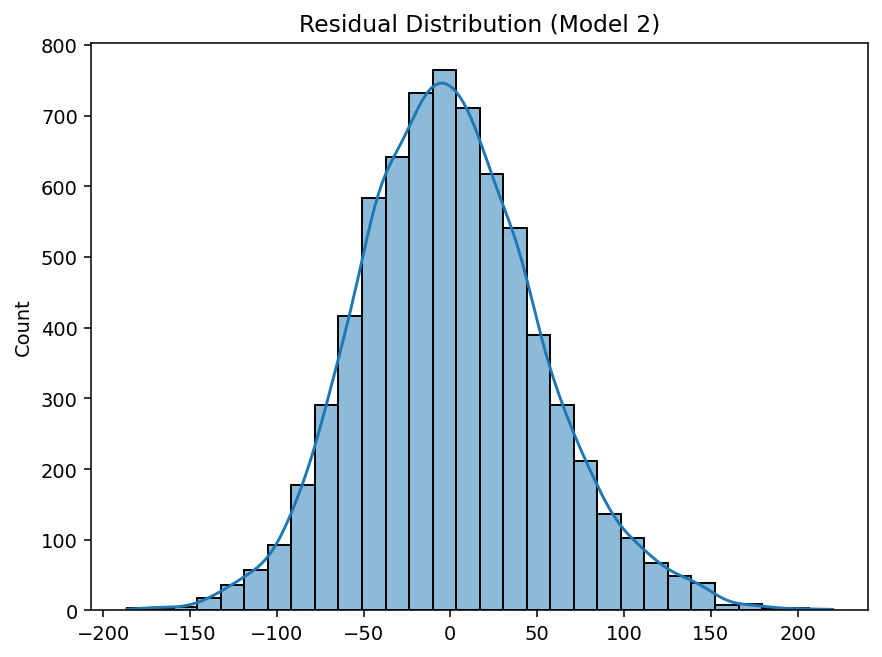


Normality Tests on Residuals (Model 2):
Shapiro–Wilk: stat=0.995, p=0.000
Jarque–Bera: stat=117.962, p=0.000
Anderson–Darling (approx): stat=7.830, p=0.000

Breusch–Pagan Test for Heteroskedasticity:
Lagrange multiplier statistic: 264.5342
p-value: 0.0000
f-value: 39.2299
f p-value: 0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7000.
  res = hypotest_fun_out(*samples, **kwds)


In [20]:
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from scipy.stats import shapiro, jarque_bera

# --- Build predictor matrix with dummies
X = pd.get_dummies(
    work[["AI_Pricing_System","Event_Flag","Star_Rating","Hotel_Segment","Year"]],
    drop_first=True
)

# Force everything numeric
X = X.astype(float)
X = sm.add_constant(X)
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# --- Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors (VIF):")
display(vif_data)

# --- Residuals from Model 2 (AI × Event model)
resid = m2.resid
fitted = m2.fittedvalues

# Residual vs Fitted
plt.figure()
sns.scatterplot(x=fitted, y=resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
plt.title("Residual vs Fitted (Model 2)")
plt.tight_layout()
plt.savefig(fig_dir/"residuals_model2.png")
plt.show()

# Histogram of residuals
plt.figure()
sns.histplot(resid, bins=30, kde=True)
plt.title("Residual Distribution (Model 2)")
plt.tight_layout()
plt.savefig(fig_dir/"residuals_hist_model2.png")
plt.show()

# --- Normality tests
print("\nNormality Tests on Residuals (Model 2):")
shapiro_stat, shapiro_p = shapiro(resid)
print(f"Shapiro–Wilk: stat={shapiro_stat:.3f}, p={shapiro_p:.3f}")

jb_stat, jb_p = jarque_bera(resid)
print(f"Jarque–Bera: stat={jb_stat:.3f}, p={jb_p:.3f}")

ad_stat, ad_p = normal_ad(resid)
print(f"Anderson–Darling (approx): stat={ad_stat:.3f}, p={ad_p:.3f}")

# --- Heteroskedasticity test (Breusch–Pagan)
bp_test = het_breuschpagan(resid, m2.model.exog)
labels = ['Lagrange multiplier statistic','p-value','f-value','f p-value']
print("\nBreusch–Pagan Test for Heteroskedasticity:")
for name, val in zip(labels, bp_test):
    print(f"{name}: {val:.4f}")